In [122]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
import os
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Read in Data and Preprocess

In [98]:
true_news_df = pd.read_csv("COVID19-FNIR/COVID19-FNIR/trueNews.csv")
fake_news_df = pd.read_csv("COVID19-FNIR/COVID19-FNIR/fakeNews.csv")

In [99]:
# Assign class columns and combine dataframes
fake_news_df["class"] = 0
true_news_df["class"] = 1
combined = pd.concat([fake, real], axis=0)

In [100]:
# Subset data to just contain the text field and the class field
combined = combined[["Text", "class"]].reset_index(drop=True)
# Shuffle data
combined = combined.sample(frac = 1)

In [ ]:
combined.head()

In [102]:
def wordopt(text):
    """Formating of the text field """
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text



In [103]:
combined["Text"] = combined["Text"].apply(wordopt)

In [104]:
combined.head()

,Text,class
4515,in the list of countries with highest number o...,1
6745,the man who was kept at a quarantine centre i...,1
1354,president trump did sign a bill but exposure...,0
6384,covid free health certificates have been made...,1
3008,in tamil nadu s vellore muslims are offering...,0


In [105]:
# Set X and y variables
X = combined["Text"]
y = combined["class"]

In [109]:
# Split data into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html 

vectorization = TfidfVectorizer()
X_train = vectorization.fit_transform(X_train)
X_test = vectorization.transform(X_test)

In [111]:
# Model 1: Simple Sklearn Logistic Regression Model

In [115]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
lr_model = LogisticRegression()
# Fit model 
lr_model.fit(X_train, y_train)
# Predict 
y_pred = lr_model.predict(X_test)

In [117]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.9905113336847654


In [118]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       910
           1       1.00      0.98      0.99       987

    accuracy                           0.99      1897
   macro avg       0.99      0.99      0.99      1897
weighted avg       0.99      0.99      0.99      1897



In [119]:
# Add confusion matrix and roc plot, maybe calulate some other metrics as well

In [121]:
plot_conf_matrix(y_pred, y_test)

NameError: name 'confusion_matrix' is not defined

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = [[13,1,1,0,2,0],
         [3,9,6,0,1,0],
         [0,0,16,2,0,0],
         [0,0,0,13,0,0],
         [0,0,0,0,15,0],
         [0,0,1,0,0,15]]

df_cm = pd.DataFrame(array, range(6), range(6))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [135]:
def plot_conf_matrix(y_pred, y_true, title):
    conf_mat = confusion_matrix(y_pred, y_true)
    df_cm = pd.DataFrame(conf_mat, index = [i for i in ["Fake", "Real"]],
                  columns = [i for i in ["Fake", "Real"]])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="Blues")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title()
    plt.show()

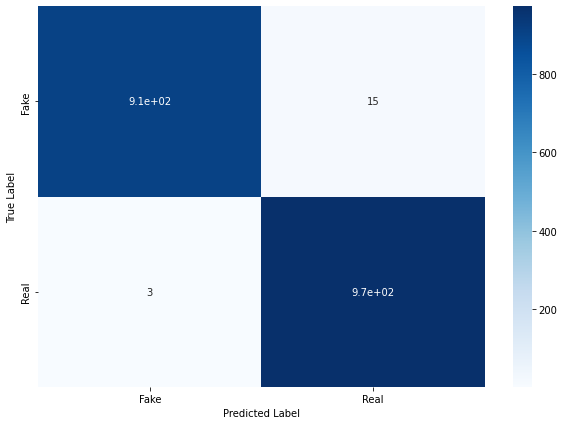

In [136]:
plot_conf_matrix(y_pred, y_test)

In [70]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(xv_train, y_train)

DecisionTreeClassifier()

In [71]:
pred_dt = DT.predict(xv_test)

In [72]:
DT.score(xv_test, y_test)

0.9905113336847654

In [73]:
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       922
           1       0.99      0.99      0.99       975

    accuracy                           0.99      1897
   macro avg       0.99      0.99      0.99      1897
weighted avg       0.99      0.99      0.99      1897



In [74]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier(random_state=0)
GBC.fit(xv_train, y_train)


GradientBoostingClassifier(random_state=0)

In [75]:
pred_gbc = GBC.predict(xv_test)

In [77]:
GBC.score(xv_test, y_test)

0.992619926199262

In [76]:
print(classification_report(y_test, pred_gbc))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       922
           1       1.00      0.99      0.99       975

    accuracy                           0.99      1897
   macro avg       0.99      0.99      0.99      1897
weighted avg       0.99      0.99      0.99      1897



In [78]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(random_state=0)
RFC.fit(xv_train, y_train)

RandomForestClassifier(random_state=0)

In [79]:
pred_rfc = RFC.predict(xv_test)

In [80]:
RFC.score(xv_test, y_test)

0.992619926199262

In [83]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       922
           1       1.00      0.99      0.99       975

    accuracy                           0.99      1897
   macro avg       0.99      0.99      0.99      1897
weighted avg       0.99      0.99      0.99      1897



In [85]:
import gensim

In [88]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100
#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=x, size=EMBEDDING_DIM, window=5, min_count=1)

TypeError: __init__() got an unexpected keyword argument 'size'

In [89]:
x

5340    the tamil nadu government on monday announced ...
6332     coronavirus will be exterminated if lockdowns...
3950     coronavirus update from mumbai   source   pti...
6715    about  railway coaches converted into  covid c...
3672    where is the testing    rosena allin khan ques...
                              ...                        
3776     says goodwill used the pandemic  to fire all ...
5970    india  u s  to collaborate on  covid  vaccine ...
2433     audio from whatsapp that says there are a doc...
2105    uk economy to struggle to recover from  searin...
1075    australia s drug regulator launches court acti...
Name: Text, Length: 7588, dtype: object